In [179]:
#Importar librerías necesarias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg

In [180]:
#Carga y filtro de los datos por tipo de magnitud

data = pd.read_csv('sismologia_db.csv')
data=data[data['PROFUNDIDAD']>50] #profundos
#data=data[data['PROFUNDIDAD']<=50] #someros
data

,ANO,MES,DIA,LATITUD,LONGITUD,PROFUNDIDAD,COLOR,Ml,SIZE,Mw,DEPARTAMENTO,MUNICIPIO,X,Y
0,2001,1,14,6.591,-73.070,214.8,1,2.3,2,NaN,SANTANDER,CURITI,1111807.466,1220394.417
1,2004,5,4,6.636,-73.355,208.3,1,2.3,2,NaN,SANTANDER,GALAN,1080277.712,1225316.756
2,2001,2,12,6.985,-73.347,202.5,1,2.5,2,NaN,SANTANDER,BETULIA,1081104.106,1263917.405
3,2003,6,1,5.823,-73.994,201.6,1,2.4,2,NaN,SANTANDER,FLORIAN,1009627.383,1135350.814
4,2000,6,25,6.312,-73.061,200.0,1,3.8,10,NaN,SANTANDER,COROMORO,1112864.450,1189537.218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38644,2001,4,15,7.225,-73.732,54.0,1,2.3,2,NaN,SANTANDER,PUERTO_WILCHES,1038538.733,1290411.505
38645,2002,8,8,6.488,-73.609,52.4,1,2.2,2,NaN,SANTANDER,SANTA_HELENA_DEL_OPON,1052203.436,1208915.186
38646,2001,4,11,6.529,-73.857,52.4,1,2.0,2,NaN,SANTANDER,PUERTO_PARRA,1024768.301,1213430.765
38647,2010,4,4,6.582,-74.027,52.0,1,2.0,2,NaN,SANTANDER,PUERTO_PARRA,1005964.538,1219286.977


In [181]:
df_punto2 = data[['X','Y','PROFUNDIDAD']]

In [182]:
#Cálculo del centroide

z=df_punto2['PROFUNDIDAD']*-1000
y=df_punto2['Y']
x=df_punto2['X']

z_prom=np.mean(z)
x_prom=np.mean(x)
y_prom=np.mean(y)

puntocentral=np.vstack((x_prom, y_prom, z_prom))
puntocentral

array([[1108368.41427672],
       [1242612.84847246],
       [-144111.24479288]])

In [183]:
# Cálculo de N, Cr y la distancia al centroide

dist=np.sqrt(((x-x_prom)**2)+((y-y_prom)**2)+((z-z_prom)**2))
N=len(df_punto2)

def Nvalues(dist, r):
    Nv=np.count_nonzero(dist < r)
    Nv=np.mean(Nv)
    return Nv

def cr(Nr,N):
    cr=(2*Nr)/(N*(N-1))
    return cr

amin = np.ceil(np.min(dist))
amax = np.ceil(np.max(dist))

r=np.linspace(amin, amax, N)
c=np.zeros(len(r))
Nr=np.zeros(len(r))

for i in range (len(r)):
    Nr[i] = Nvalues(dist, r[i])
    
for i in range (len(r)):
    c[i]=cr(Nr[i],N)
    
amin

282.0

In [184]:
#Definición de las variables r y c

df_punto2['r']=r 
df_punto2['c']=c 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [185]:
#Definir límite de la regresión

Limite=25000
valo_1= df_punto2['r'] < Limite
x=np.log10(df_punto2['r'][valo_1]) 
y=np.log10(df_punto2['c'][valo_1])

def predlog(x0, x):
    return 10**(x0[0] + (x0[1]*np.log10(x)))

In [186]:
#Realizar regresión por la norma L1

from scipy import stats
slope, intercept, r_value, p_value, std_err=stats.linregress(x,y)
r2_value=r_value*r_value
lreg=np.vstack((intercept, slope, r2_value))
lreg

array([[-13.19685158],
       [  2.07646586],
       [  0.93870014]])

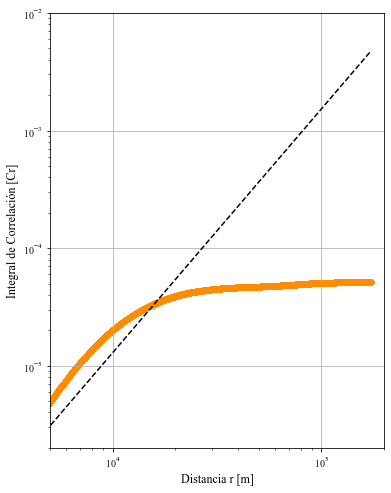

In [187]:
plt.rcParams.update({'font.family':'Times New Roman'})

df_punto2.plot.scatter(x="r", y="c", c="darkorange", figsize=(6,8))
plt.xlabel('Distancia r [m]', fontsize=12)
plt.ylabel('Integral de Correlación [Cr]', fontsize=12)
plt.yscale("log")
plt.xscale("log")
plt.plot(r, predlog(lreg, r), 'k--')
plt.xlim(5e3,2e5)
plt.ylim(2e-6,1e-2)
plt.grid()

plt.savefig('fractal.png', dpi=400)


In [188]:
r.min()

282.0